In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv


In [2]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings("ignore")

Read data

In [3]:
sale_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
item_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')

Convert date column to datetime dtype

In [4]:
sale_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


**Aggregate to monthly sale for each shop item pair**

In [5]:
print('Original dtypes', sale_df.info())
sale_df.date = sale_df.date.apply(lambda x: datetime.datetime.strptime(x,"%d.%m.%Y"))
print(sale_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
Original dtypes None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [6]:
sale_agg = sale_df.groupby(["date_block_num", "shop_id","item_id"])["item_cnt_day","item_price"].agg({'item_cnt_day' : 'sum', 'item_price':'mean'}) 
sale_agg

item_cnt_day  item_price
date_block_num shop_id item_id                          
0              0       32                6.0       221.0
                       33                3.0       347.0
                       35                1.0       247.0
                       43                1.0       221.0
                       51                2.0       128.5
...                                      ...         ...
33             59      22087             6.0       119.0
                       22088             2.0       119.0
                       22091             1.0       179.0
                       22100             1.0       629.0
                       22102             1.0      1250.0

[1609124 rows x 2 columns]

In [7]:
item_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Count number of items in each category

In [8]:
# number of items per cat 
x=item_df.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x


,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


**Plot no of items in each category.**

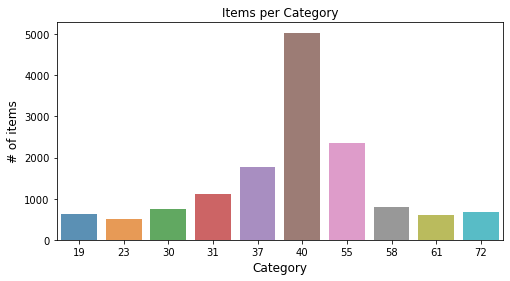

In [9]:
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

# **Plot total sales per month.**

The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.

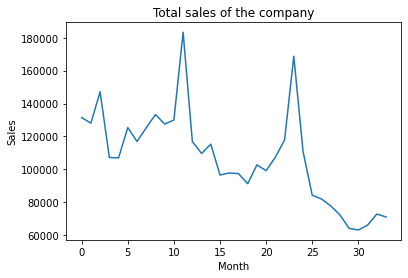

In [10]:
sales_pm = sale_df.groupby(["date_block_num"]).agg({'item_cnt_day':'sum'})
plt.title('Total sales of the company')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.plot(sales_pm)

Plot rolling mean and standard deviation with a window of 12( one year)

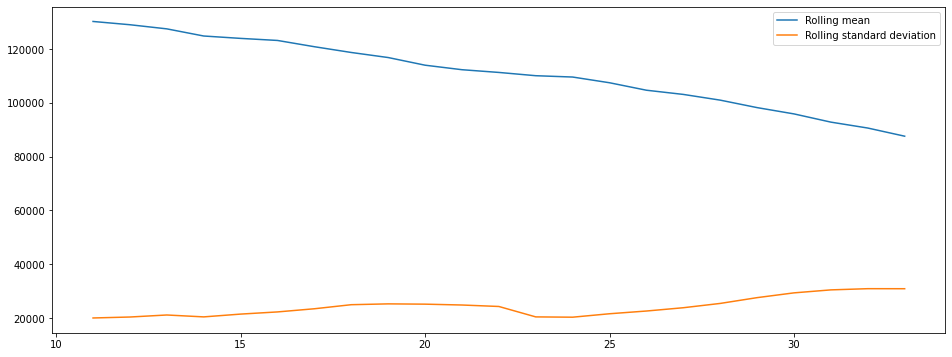

In [11]:
rolling_window = sales_pm.rolling(12)
plt.figure(figsize= (16,6))
plt.plot(rolling_window.mean(), label = "Rolling mean")
plt.plot(rolling_window.std(), label = "Rolling standard deviation")
plt.legend()

# Quick observations: 
There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

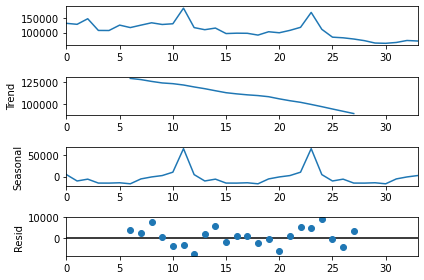

In [12]:
result1 = sm.tsa.seasonal_decompose(sales_pm,model='additive', freq=12)
fig1 = result1.plot()

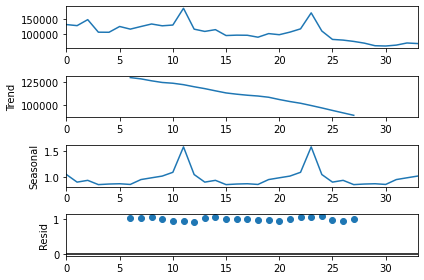

In [13]:
result2 = sm.tsa.seasonal_decompose(sales_pm, model ='multiplicative', freq=12)
fig2 = result2.plot()

# Stationarity:

Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.

There are multiple tests that can be used to check stationarity.

ADF( Augmented Dicky Fuller Test)
KPSS
PP (Phillips-Perron test)
Let's just perform the ADF which is the most commonly used one.

In [14]:
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

In [15]:
adf_test(sales_pm)

ADF Statistic: -2.3957040669944325
p-value: 0.1429525769929046
Critial Values:
   1%, -3.6461350877925254
Critial Values:
   5%, -2.954126991123355
Critial Values:
   10%, -2.6159676124885216


The ADF Statistic value should be less than all critical values and p-value should be within 5% for data to be stationary. This is not the case here. So we de-trend the data first to check whether data is stationary or not.

In [45]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

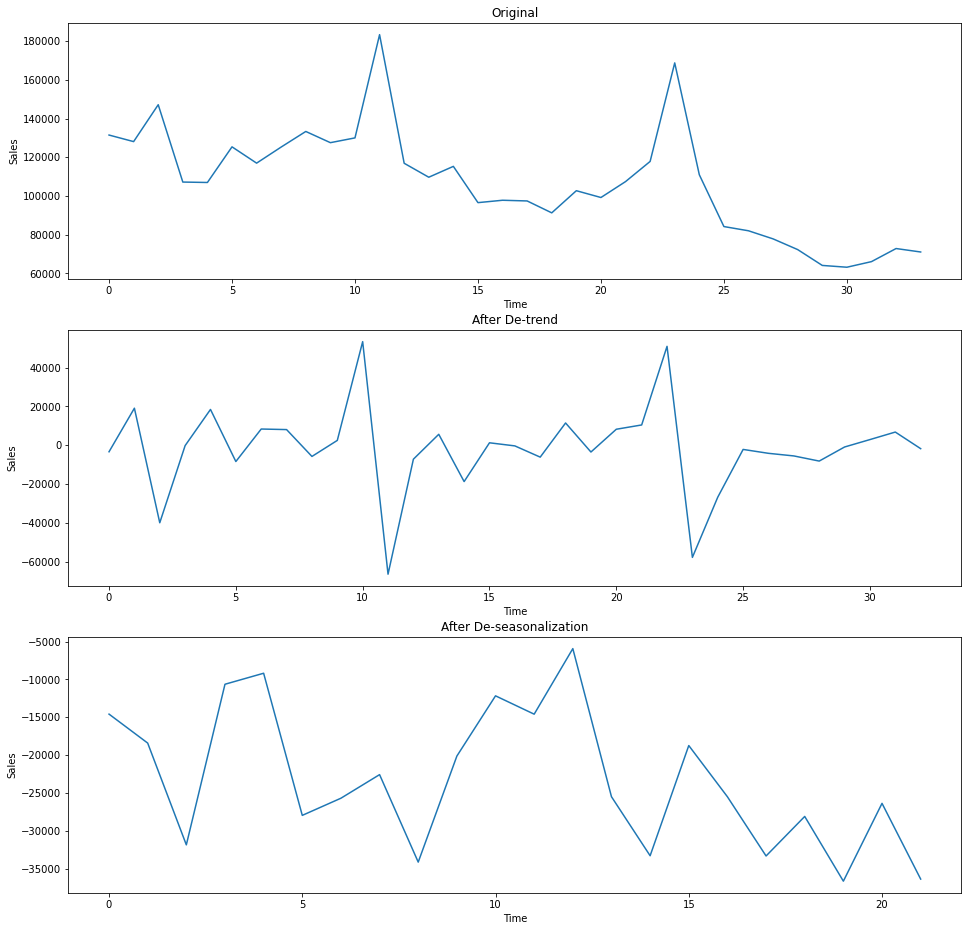

In [46]:
ts=sales_pm.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [47]:
adf_test(new_ts)

ADF Statistic: -3.270101192815549
p-value: 0.01626900992370418
Critial Values:
   1%, -3.7883858816542486
Critial Values:
   5%, -3.013097747543462
Critial Values:
   10%, -2.6463967573696143


From the statistics, we see that the data is stationary now. We also check for 12 lag differenced on the de-trended data to check its stationarity.

We achieved better stationarity of the data with only de-trending. Hence we will use that data itself. 
Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series. 
We can easily get back the original series using the inverse transform function that we have defined above.

# **AR, MA and ARMA models:**
TL: DR version of the models:

MA - Next value in the series is a function of the average of the previous n number of values AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values ARMA - a mixture of both.

Now, How do we find out, if our time-series in AR process or MA process?

Let's find out!

In [18]:
def tsplot(y, lags = None, figsize = (10,8), style ='bmh', title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax=plt.subplot2grid(layout, (0,0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))
        qq_ax = plt.subplot2grid(layout,(2,0))
        pp_ax = plt.subplot2grid(layout,(2,1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags = lags, ax= acf_ax, alpha = 0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax,alpha = 0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams =(y.mean(),y.std()), plot=pp_ax )
        plt.tight_layout()
    return

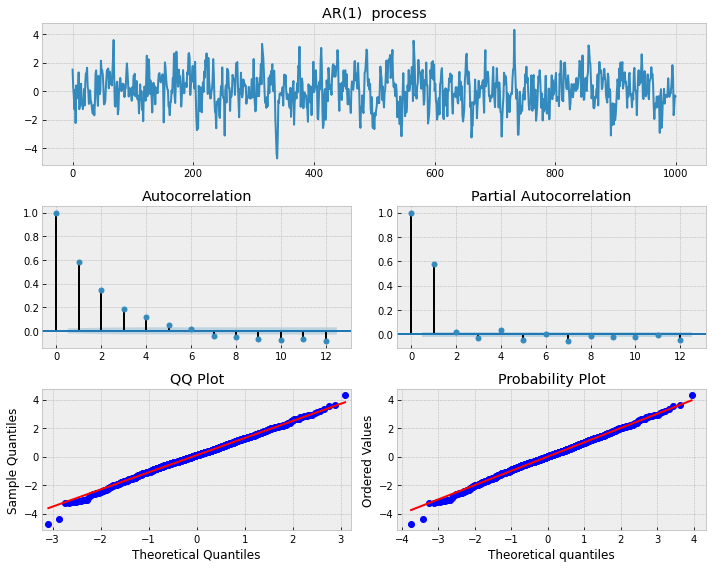

In [19]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = 1000
alpha = 0.6
x = w = np.random.normal(size = n_samples)
for t in range(n_samples):
    x[t] = alpha * x[t-1] + w[t]
_ = tsplot(x, lags = 12,title = "AR(1)  process" )

# AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

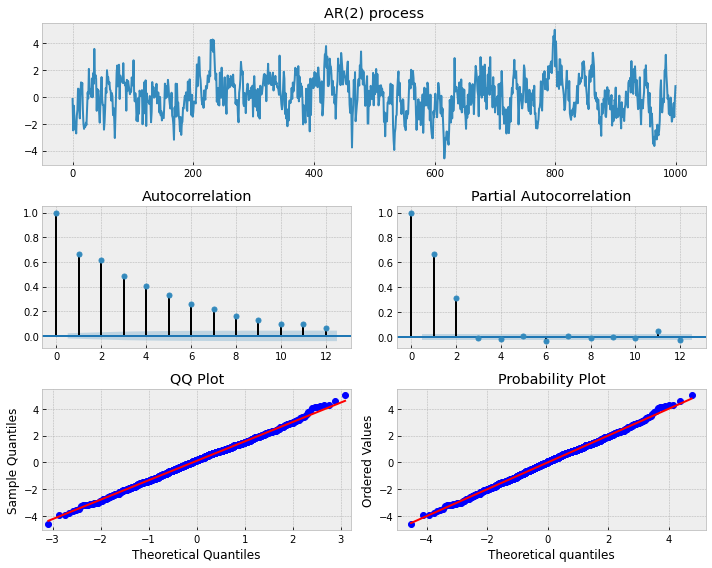

In [20]:
# Simulate an AR(2) process
n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma= ma, nsample = n)
_ = tsplot(ar2, lags=12, title = "AR(2) process")

# AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

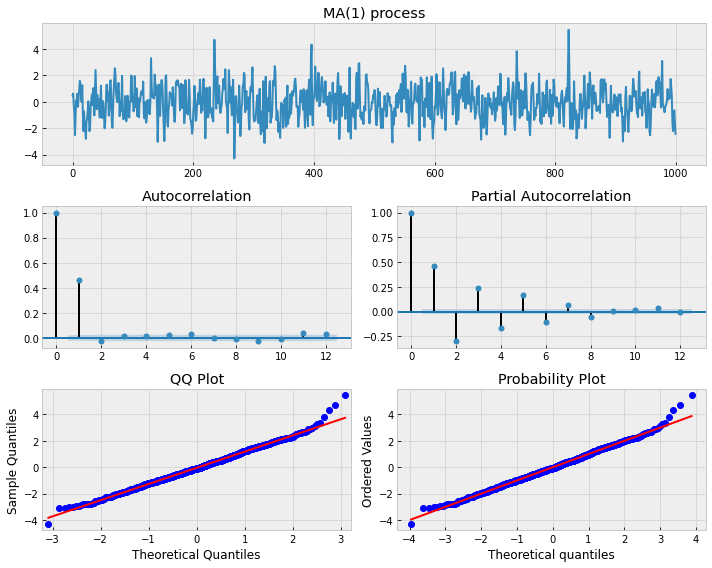

In [21]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

# MA(1) process -- has ACF cut off at lag=1

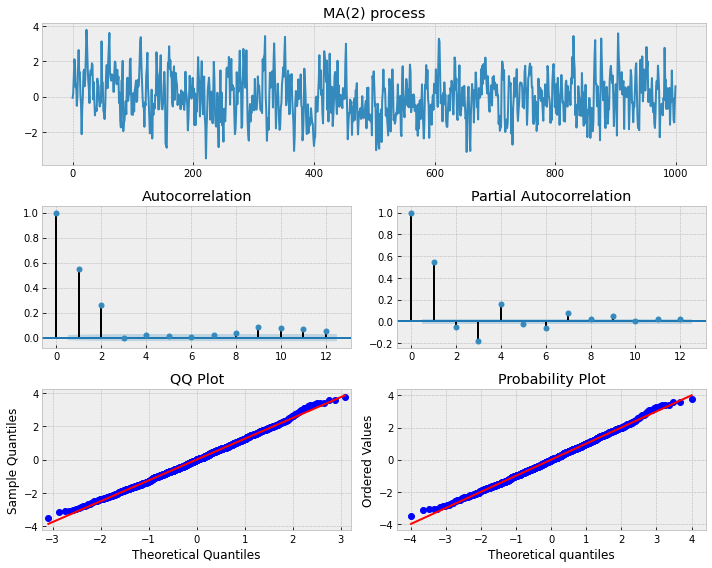

In [22]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

# MA(2) process -- has ACF cut off at lag=2

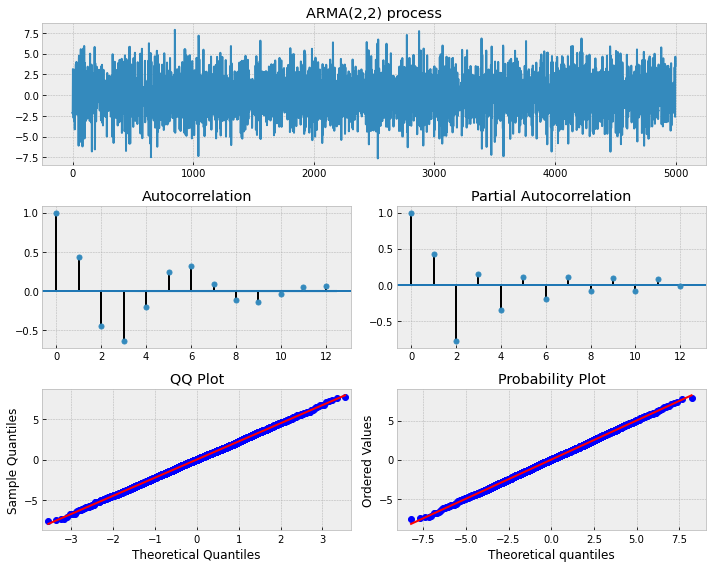

In [23]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

Let's use a systematic approach to finding the order of AR and MA processes.

In [48]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


**We've correctly identified the order of the simulated process as ARMA(2,2).**
Lets use it for the sales time-series.

In [49]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            # mle = most likelihood estimate, nc = no constant
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


Thus we find the order of our data is ()

Simply use best_mdl.predict() to predict the next values


In [26]:
ts = sale_df.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index = pd.date_range(start = '2013-01-01', end = '2015-10-01', freq='MS')
ts = ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


# Prophet:
Recently open-sourced by Facebook research. It's a very promising tool, that is often a very handy and quick solution to the frustrating flatline

In [27]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

In [28]:
# predict for five months in the future and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957416,80157.850375,86253.822089
35,2015-12-01,125513.063181,122507.615026,128527.677097
36,2016-01-01,75625.688717,72334.504507,78761.262254
37,2016-02-01,40109.144632,36826.924195,43146.889650
38,2016-03-01,76664.084927,73570.380130,79724.132128


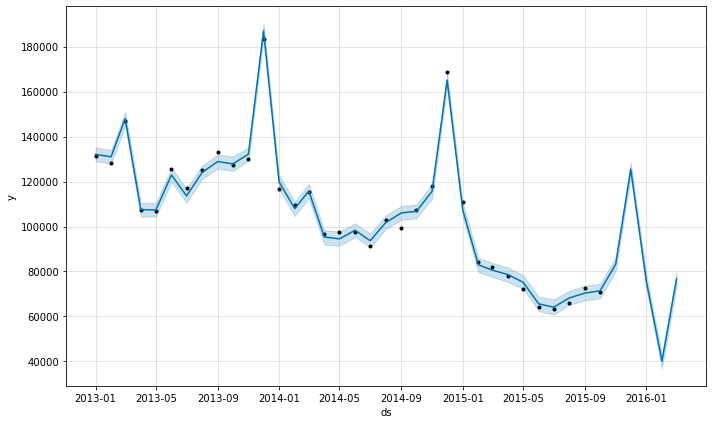

In [29]:
fig = model.plot(forecast)

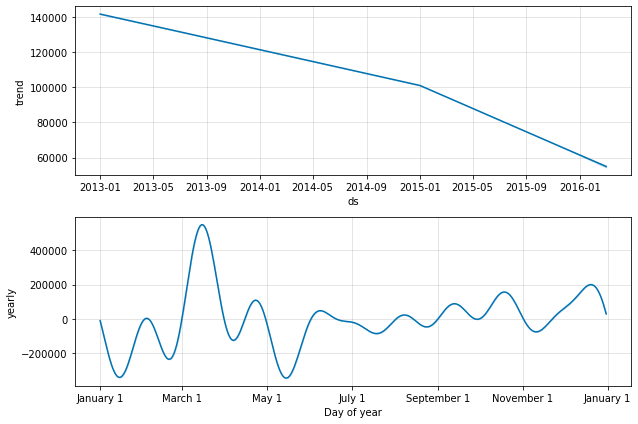

In [30]:
fig2 = model.plot_components(forecast)

In [31]:
total_sales = sale_df.groupby(["date_block_num"])['item_cnt_day'].sum()
dates = pd.date_range(start= '2013-01-01', end = '2015-10-01', freq = 'MS')
total_sales.index = dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [32]:
# get the unique combinations of item-store from the sales data at monthly level
sale_pm_item = sale_df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum()

# arrange it conviniently to perform the hts 
sale_pm_item = sale_pm_item.unstack(level = -1).fillna(0)
sale_pm_item = sale_pm_item.T
dates = pd.date_range(start = '2013-01-01', end = '2015-10-01',freq = 'MS')
sale_pm_item.index = dates
sale_pm_item = sale_pm_item.reset_index()
sale_pm_item.head()

shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

In [33]:
import time
start_time = time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py

forecastsDict = {}

for node in range(len(sale_pm_item[0])):
    nodeToForecast = pd.concat([sale_pm_item.iloc[:,0], sale_pm_item.iloc[:,node+1]], axis = 1)
    # rename for prophet compatability
    nodeToForecast.columns = ["ds", "y"]
    growth = 'linear'
    model = Prophet(growth, yearly_seasonality = True)
    model.fit(nodeToForecast)
    future = model.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = model.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break
    
    

forecasting for  10 th node and took 32.43529915809631 s


**Middle out:**
* Let's predict for the store level

In [34]:
sale_pm_shop = sale_df.groupby(["date_block_num", "shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
sale_pm_shop = sale_pm_shop.unstack(level = 1)
sale_pm_shop = sale_pm_shop.fillna(0)
sale_pm_shop.index = dates 
sale_pm_shop = sale_pm_shop.reset_index()
sale_pm_shop.head()

shop_id,index,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,...,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,...,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,...,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,...,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,...,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0


In [35]:
start_time = time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet package -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py

forecastsDict = {}

for node in range(len(sale_pm_shop[0])):
    nodeToForecast = pd.concat([sale_pm_shop.iloc[:,0], sale_pm_shop.iloc[:,node+1]], axis = 1)
    # rename for prophet compatability
    nodeToForecast.columns = ["ds", "y"]
    growth = 'linear'
    model = Prophet(growth, yearly_seasonality = True)
    model.fit(nodeToForecast)
    future = model.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = model.predict(future)
    

In [36]:
for key in range(len(forecastsDict.keys())):
    
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:,np.newaxis]
    if key == 0:
        predictions = f2.copy()
    else:
        predictions = np.concatenate((predictions, f2), axis = 1)

In [37]:
predictions[-1]

array([  240.81393204,   116.28589275,  1107.78682599,   888.86026388,
        1465.17303431,  1311.88427115,  2553.96936873,  1874.98195159,
        -103.61300882,   581.58037786,   706.7584699 ,    29.36442879,
        3684.86252823,  -533.01327161,  1125.91098768,  2102.61611136,
        1235.63309739,  1620.531595  ,  1507.99916018,  1901.9932538 ,
        -681.46090572,  2090.00319908,  1744.75630904,  -742.48402473,
        2329.36463879,  6642.37729189,  1533.46139986,  6841.03565345,
        4470.31106098,   145.57284766,   296.75210806,  8209.01135323,
       -1266.81428446,   775.5725287 ])